In [2]:
import warnings
warnings.filterwarnings('ignore')

C:\Users\janne\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR! Session/line number was not unique in database. History logging moved to new session 255


In [1]:
import ijson
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FuzzyTM
import seaborn as sns
import nltk
import re, random, os
import string, pprint
import seaborn as sns

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LsiModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Loading in the Data

In [3]:
# Load the documents into a documents list
documents = []

with open("../Source/data.json", "rb") as j:
    for record in ijson.items(j, "item"):
        documents.append(record)

In [5]:
documents[1]

{'document_identifier': '00cefb93dbb1b390d47ae839b74b7b83',
 'document_title': 'Landbouw- en Visserijraad',
 'type_primary': 'Kamerstuk',
 'type_secondary': 'Inbreng verslag schriftelijk overleg',
 'published': '2021-10-05 00:00:00',
 'publisher': {'role': 'Publisher',
  'person': None,
  'function': None,
  'organisation': 'Tweede Kamer',
  'department': None},
 'source': {'site': 'tweedekamer.nl', 'label': 'Tweede Kamer'},
 'document_url': 'https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Document(213597dd-edf1-49fb-ad46-b53334f2b62c)/resource',
 'author': [{'role': 'Mede ondertekenaar',
   'person': 'L.L. Nouse',
   'function': 'adjunct-griffier',
   'organisation': 'Tweede Kamer',
   'department': None},
  {'role': 'Eerste ondertekenaar',
   'person': 'A.H. Kuiken',
   'function': 'voorzitter van de vaste commissie voor Landbouw, Natuur en Voedselkwaliteit',
   'organisation': 'Tweede Kamer',
   'department': 'PvdA'}],
 'subjects': [],
 'content': '2021D36963 INBRENG VERSLAG VA

In [4]:
doc_titles = []
for doc in documents:
    doc_titles.append(doc['document_title'])
    

doc_content = []
for doc in documents:
    doc_content.append(doc['content'])

In [5]:
data = {'Title': doc_titles, 'Content': doc_content}

In [6]:
df_NLP = pd.DataFrame(data)
df_NLP

,Title,Content
0,Contaminatie in het vlees van ‘grote grazers’ ...,> Retouradres Postbus 20350 2500 EJ Den Haag D...
1,Landbouw- en Visserijraad,2021D36963 INBRENG VERSLAG VAN EEN SCHRIFTELIJ...
2,2022-10-12 Motie GL - Bestemmingsplan Snipperg...,Motie MOTIE Raadsvergadering 12 oktober 2022 A...
3,Brief van de minister van LNV over de stand va...,Eerste Kamer der Staten-Generaal 1 Vergaderjaa...
4,Reactie op het speciaal verslag 'EU-financieri...,Tweede Kamer der Staten-Generaal Postbus 20018...
...,...,...
968,Handhaving milieuwetgeving,2021D43560 INBRENG VERSLAG VAN EEN SCHRIFTELIJ...
969,20220917 I. Stokkingreef - XL businesspark 2 -...,Steeds meer maakt niet gelukkig Beste raadsled...
970,Verslag Landbouw- en Visserijraad 13 juni 2022,Vergaderjaar 2021-2022 Tweede Kamer der Staten...
971,Antwoord op vragen van het lid Boswijk over he...,Tweede Kamer der Staten-Generaal 2 Vergaderjaa...


# Text preprocessing

The preprocessing pipeline is mentioned below.
#### 1. Tokenisation
First basic tokenization is implemented, to split the text into 
tokens as is recommended by Kannan et al. (2014). For this process I used genism’s 
simple_preprocess, which will convert the text into lowercase & tokens and remove punctuation.  

In [7]:
# Tokenization using gensim
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  
        
# Convert the data to a list
data = df_NLP['Content'].values.tolist()
data_words = list(sent_to_words(data))

# Preview of the data
print(data_words[1])

['inbreng', 'verslag', 'van', 'een', 'schriftelijk', 'overleg', 'binnen', 'de', 'vaste', 'commissie', 'voor', 'landbouw', 'natuur', 'en', 'hebben', 'de', 'onderstaande', 'fracties', 'de', 'behoefte', 'vragen', 'en', 'opmerkingen', 'voor', 'te', 'leggen', 'aan', 'de', 'minister', 'van', 'landbouw', 'natuur', 'en', 'over', 'de', 'informele', 'landbouwen', 'visserijraad', 'van', 'en', 'oktober', 'de', 'fungerend', 'voorzitter', 'van', 'de', 'commissie', 'kuiken', 'de', 'adjunct', 'griffier', 'van', 'de', 'commissie', 'nouse', 'nds', 'tk', 'inhoudsopgave', 'blz', 'vragen', 'en', 'opmerkingen', 'vanuit', 'de', 'fracties', 'vragen', 'en', 'opmerkingen', 'van', 'de', 'leden', 'van', 'de', 'vvd', 'fractie', 'vragen', 'en', 'opmerkingen', 'van', 'de', 'leden', 'van', 'de', 'fractie', 'vragen', 'en', 'opmerkingen', 'van', 'de', 'leden', 'van', 'de', 'cda', 'fractie', 'vragen', 'en', 'opmerkingen', 'van', 'de', 'leden', 'van', 'de', 'pvdd', 'fractie', 'vragen', 'en', 'opmerkingen', 'van', 'de', '

#### 2. Stop word removal 
Secondly stop words will be removed from the data as well as a list of punctuation characters from 
the string.punctiation string, which is a pre-initialized string used as a string constant. These are 
removed because they have little relevance for understanding the content of a text (Kannan et al., 
2014).

In [8]:
# Create stopword list
# string.punctuation refers to a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch') + list(string.punctuation)

In [9]:
# Removing the stopwords from the data
def rem_stopwords (text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]

# remove stop words
data_words_nostops = rem_stopwords(data_words)

#### 3. Lemmatization

Lastly lemmatization has been performed, since its superior to stemming (Khyani et al., 2021), 
which is a text normalization technique that will switch any word to its lemma. For this process I 
used to open-source software library called spaCy, but NLTK could also have been used. The spaCy 
pre-trained model called en_core_web_md, can be thought of as some kind of pipeline. When this 
model is called upon a text or word, the text will run through the pipeline. If the text isn’t tokenized 
it will be tokenized after which different components will be activated. The thing that’s most 
interesting about this pipeline is a tagger which will assign Part-of-Speech tags based on spaCy’s 
English language model. This is done to gain a variety of annotations. The POS tag refers to a label 
which will be assigned to every token in the corpus to indicate the type of said token (is it a verb or 
punctation or adjective) and other grammatical categories. These POS tags can then be used in the 
preprocess to remove unwanted tags. The only tags that I have allowed in my analysis are Noun, Adj, 
Verb and Adv.

In [10]:
spacy.load("nl_core_news_lg")

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('nl_core_news_lg', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
df_NLP['Content'] = data_lemmatized
df_NLP

,Title,Content
0,Contaminatie in het vlees van ‘grote grazers’ ...,"[retouradres, postbus, staat, generaal, Postbu..."
1,Landbouw- en Visserijraad,"[inbreng, verslag, schriftelijk, overleg, vast..."
2,2022-10-12 Motie GL - Bestemmingsplan Snipperg...,"[motie, motie, agendapunt, bestemmingplan, sni..."
3,Brief van de minister van LNV over de stand va...,"[één, kamer, staat, generaal, vergaderjaar, pr..."
4,Reactie op het speciaal verslag 'EU-financieri...,"[Tweede, staat, generaal, Postbus, tweedekamer..."
...,...,...
968,Handhaving milieuwetgeving,"[inbreng, verslag, schriftelijk, overleg, vast..."
969,20220917 I. Stokkingreef - XL businesspark 2 -...,"[steeds, maken, gelukkig, goed, raadlid, gemee..."
970,Verslag Landbouw- en Visserijraad 13 juni 2022,"[vergaderjaar, generaal, kamerstukak, landbouw..."
971,Antwoord op vragen van het lid Boswijk over he...,"[Tweede, staat, generaal, vergaderjaar, aanhan..."


# Data transformation: Corpus and Dictionary

In [12]:
# create dictionary and corpus
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# Exploring various models

The output of the topic model consists of several topics, in this case 10, where each single topics is a 
collection of words in the collection of documents, meaning that the quality of the topics model 
should focus on the quality of words within each topic and the diversity between all the obtained 
topics. The coherence score covers how well the words in a topic support each other whereas the 
diversity obviously shows how diverse each topic is, which is 1 in the case of FLSA-W since it clusters 
word explicitly. Interpretability combines both.

## a) LDA model

LDA stands for Latent Dirichlet Allocation and is an unsupervised Generative probabilistic machine 
learning technique which is used for extracting a number of topics in the data (corpus), the 
distribution of the topics in each document and the distribution of words in each topic. The idea 
behind LDA is that there are different words which can be descriptors for a certain topic, and the 
algorithm will calculate the probability of each word in the documents aligning to one of the topics 
which have been identified by the algorithm. This will allow regulars to come and look at all these 
different words describing a certain topic and giving them names based on what these topics could 
mean or represent.

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           iterations = 50,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"gebied" + 0.011*"natuur" + 0.006*"maatregel" + 0.006*"provincie" + '
  '0.006*"landbouw" + 0.006*"maken" + 0.005*"goed" + 0.005*"jaar" + '
  '0.005*"komen" + 0.005*"gaan"'),
 (1,
  '0.022*"gaan" + 0.019*"minister" + 0.015*"heer" + 0.014*"voorzitter" + '
  '0.014*"wel" + 0.011*"heel" + 0.010*"komen" + 0.010*"vraag" + 0.009*"zeggen" '
  '+ 0.009*"goed"'),
 (2,
  '0.013*"agenda" + 0.011*"landbouw" + 0.010*"commissie" + 0.009*"natuur" + '
  '0.009*"zaak" + 0.009*"brief" + 0.008*"besluit" + 0.008*"activiteit" + '
  '0.008*"programma" + 0.008*"parlis"'),
 (3,
  '0.015*"lid" + 0.015*"minister" + 0.009*"Europees" + 0.008*"fractie" + '
  '0.008*"vraag" + 0.007*"commissie" + 0.007*"antwoord" + 0.005*"kamerstuk" + '
  '0.005*"landbouw" + 0.005*"Nederlands"'),
 (4,
  '0.022*"stad" + 0.018*"groen" + 0.013*"haven" + 0.011*"gemeente" + '
  '0.011*"raamwerk" + 0.010*"nieuw" + 0.010*"integraal" + '
  '0.010*"biodiversiteit" + 0.008*"park" + 0.007*"westerpark"')]


In [14]:
# perplexity score, measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# coherence score, Higher the topic coherence, the topic is more human interpretable.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.808596217502785

Coherence Score:  0.44920488500780104


## b) FLSA-W model

The FLSA-W model is known for clustering on words rather than on documents and it’s part of the 
FLSA family. FLSA is based on grouping documents which might be similar in terms of the words that 
they contain. The membership of all those documents is determined by the use of fuzzy clustering. 
However there exist the problem of documents having the possibility of containing different number 
of topics and containing different subsets of words in a certain topic. This can influence the quality of 
the clustering results which typically leads to large overlap between the topics. This will cause a 
reduction in the interpretability of the topic model obtained. Since topics can be assumed to be a 
combination of coherent words, it is reasonable to identify them in an embedding space in which 
words that are related are located nearby each other. This is what FLSA-W tries to achieve by 
clustering on words, which will reduce the problem of overlap between topics

In [15]:
from FuzzyTM import FLSA_W
flsaW = FLSA_W(input_file = data_lemmatized, num_topics=5, num_words=10)

pwgt, ptgd = flsaW.get_matrices()
topics = flsaW.show_topics(representation='words')

In [16]:
print(topics)

[['nader', 'hiermee', 'tevens', 'aanzien', 'verwachten', 'benodigd', 'mening', 'overleg', 'meenemen', 'wensen'], ['Europees', 'resultaat', 'bescherming', 'bijdragen', 'effectief', 'Nederlands', 'individueel', 'negatief', 'landbouw', 'doel'], ['proces', 'benadering', 'herstel', 'natuurlijk', 'zogeheten', 'grens', 'herstellen', 'ontstaan', 'schaal', 'wild'], ['generaal', 'handeling', 'aanhangsel', 'inzenden', 'kamerstuk', 'issn', 'lidstaat', 'griffier', 'herziening', 'wijziging'], ['noodzakelijk', 'gelden', 'kaart', 'weg', 'plan', 'behoud', 'hoog', 'leggen', 'hierdoor', 'bezwaar']]


In [17]:
#Get coherence value, higher the topic coherence, the topic is more human interpretable.
#How well the words within each topic support each other
coherence_w = flsaW.get_coherence_score(input_file = data_lemmatized, topics = topics)
print('\nCoherence Score: ', coherence_w)

#Get diversity score, whether there is word overlap between topics, probably 1 since FLSA-W clusters words explicitly. 
diversity_w = flsaW.get_diversity_score(topics = topics)
print('\nDiversity Score: ', diversity_w)

#Get interpretability score, combines both metrics and is calculated as the product between coherence and diversity.
interpret_w = flsaW.get_interpretability_score(input_file = data_lemmatized, topics = topics)
print('\nInterpretability Score: ', interpret_w)



Coherence Score:  0.46752675652972525

Diversity Score:  1.0

Interpretability Score:  0.46752675652972525


## c) Latent Semantic Analysis

Latent Semantic Analysis (LSA)
Latent Semantic Analysis (LSA) is a topic modeling method that will allow you to extract topics from 
a vast number of documents by converting the text into document-topic and word-topic matrices. 
LSA will uncover topics in documents with speed and with a high efficiency. Its procedure is 
characterized by 3 main steps:
1. Converting the text corpus into a document-term matrix, often done with the TF-IDF or bag 
of words algorithm. 
2. Implement truncated singular value decomposition.
3. Encode the words/documents with the derived topics. 

But LSA does have some drawbacks, like the loss of information which is inevitable when using LSA. 
During the conversing of the documents into a document-term matrix, the word order will be 
completely neglected, but word order does play a significant role in the semantic value of words. 
Furthermore, it’s difficult to obtain he optimal number of topics for a certain set of documents, since 
there isn’t a sure approach towards achieving this. Lastly, LSA lacks in interpretability, which makes it 
challenging to draw good insights from the topics and to determine what topic each set of words will 
represent.

In [18]:
# perform SVD on the bag of words with the LsiModel to extract 10 topics
lsi = LsiModel(corpus, num_topics=5, id2word=id2word)

In [19]:
# find the 10 words with the srongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=10):
    print('\nTopic {}: {}.'.format(topic_num, words))


Topic 0: -0.414*"stad" + -0.283*"haven" + -0.236*"raamwerk" + -0.225*"integraal" + -0.183*"gaan" + -0.169*"westerpark" + -0.159*"park" + -0.147*"groen" + -0.147*"nieuw" + -0.140*"natuur".

Topic 1: -0.275*"stad" + -0.199*"haven" + 0.191*"gaan" + -0.165*"raamwerk" + 0.161*"natuur" + 0.161*"verlies" + 0.154*"risico" + 0.145*"vrachtverkeer" + -0.144*"integraal" + 0.131*"hult".

Topic 2: -0.262*"minister" + -0.196*"gaan" + 0.186*"stad" + -0.162*"voorzitter" + -0.161*"heer" + -0.146*"wel" + 0.138*"verlies" + 0.137*"haven" + 0.125*"vrachtverkeer" + 0.113*"raamwerk".

Topic 3: 0.246*"minister" + -0.233*"gebied" + 0.228*"heer" + 0.221*"voorzitter" + -0.213*"natuur" + 0.205*"gaan" + 0.162*"heel" + -0.150*"biodiversiteit" + 0.149*"zeggen" + 0.143*"wel".

Topic 4: -0.303*"lid" + -0.236*"minister" + 0.233*"natuur" + 0.213*"groen" + 0.195*"rewilding" + -0.173*"lnv" + -0.172*"fractie" + 0.169*"gebied" + -0.149*"Europees" + 0.128*"natuurlijk".


In [20]:
#Get coherence value, higher the topic coherence, the topic is more human interpretable.
#How well the words within each topic support each other

for i in range(2,11):
    lsi = LsiModel(corpus, num_topics=i, id2word=id2word)
    coherence_model = CoherenceModel(model=lsi, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.7068676173267898
Coherence score with 3 clusters: 0.542129861083961
Coherence score with 4 clusters: 0.5817353310918725
Coherence score with 5 clusters: 0.5982212280817223
Coherence score with 6 clusters: 0.49220810986639746
Coherence score with 7 clusters: 0.5214524181007357
Coherence score with 8 clusters: 0.48652295040553295
Coherence score with 9 clusters: 0.4447280588548837
Coherence score with 10 clusters: 0.4872082543419354


# Removing high frequency and extreme words

In [21]:
# Create a dictionary and then convert it to a dataframe that shows each word in the corpus and its frequency:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

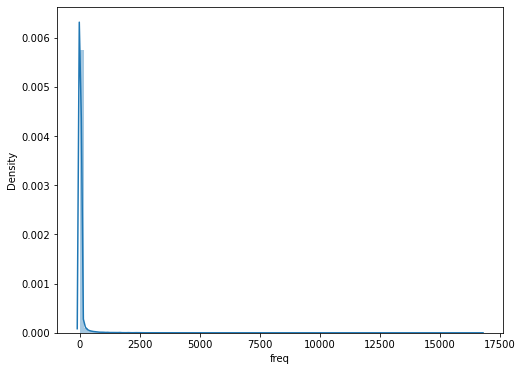

In [22]:
# Histogram that shows word frequencies to better understand the corpus:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [23]:
# Top 10 high-frequency words in descending order.
dict_df.sort_values('freq', ascending=False).head(10)

,freq
natuur,16684
gaan,16645
minister,15886
gebied,12714
komen,11386
landbouw,10400
maken,10208
goed,10047
groot,9695
biodiversiteit,9537


In [24]:
# High frequency word list
extension = dict_df[dict_df.freq>3000].index.tolist()

In [25]:
# Filtering the dictionary on high frequency words
ids=[id2word.token2id[extension[i]] for i in range(len(extension))]
id2word.filter_tokens(bad_ids=ids)

In [26]:
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 8172


In [27]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# Improve performance LDA

### Iteration 1 - removal of high frequency & extreme words

In [28]:
Iteration1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=5,
                                                  random_state=100,
                                                  update_every=1,
                                                  chunksize=100,
                                                  passes=10,
                                                  alpha='auto',
                                                  eta = 'auto',
                                                  per_word_topics=True)

In [29]:
# coherence score
coherence_model_1 = CoherenceModel(model=Iteration1, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_1 = coherence_model_1.get_coherence()
print('\nCoherence Score: ', coherence_1)

# perplexity score, measure of how good the model is. lower the better.
print('\nPerplexity: ', Iteration1.log_perplexity(corpus))  


Coherence Score:  0.6391592875156672

Perplexity:  -7.698662263729453


In [30]:
pprint.pprint(Iteration1.print_topics())
doc_lda = Iteration1[corpus]

[(0,
  '0.028*"verlies" + 0.022*"burger" + 0.017*"industrie" + 0.016*"landschap" + '
  '0.015*"advies" + 0.015*"strijd" + 0.014*"ernstig" + 0.014*"leefomgeving" + '
  '0.014*"gebouw" + 0.014*"gevaarlijk"'),
 (1,
  '0.005*"lidstaat" + 0.005*"vergaderjaar" + 0.005*"begroting" + '
  '0.005*"agenda" + 0.004*"artikel" + 0.004*"financieel" + 0.004*"budget" + '
  '0.004*"visserij" + 0.004*"totaal" + 0.003*"uitgave"'),
 (2,
  '0.017*"haven" + 0.014*"raamwerk" + 0.011*"park" + 0.008*"inspraak" + '
  '0.007*"pagina" + 0.005*"plek" + 0.005*"naam" + 0.004*"landschap" + '
  '0.004*"inwoner" + 0.004*"bewoner"'),
 (3,
  '0.006*"project" + 0.006*"natuurinclusief" + 0.006*"natura" + 0.005*"rijk" + '
  '0.004*"www" + 0.004*"hectare" + 0.004*"ministerie" + 0.004*"bouwen" + '
  '0.004*"ecologisch" + 0.004*"grond"'),
 (4,
  '0.011*"mevrouw" + 0.009*"echt" + 0.008*"kijken" + 0.007*"denken" + '
  '0.007*"graag" + 0.007*"weten" + 0.006*"zitten" + 0.005*"even" + '
  '0.005*"dank" + 0.005*"gewoon"')]


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(Iteration1, corpus, id2word)
vis

# Selection optimal number of topics

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics, 
                                                    random_state=100,
                                                    update_every=1,
                                                    iterations = 50,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

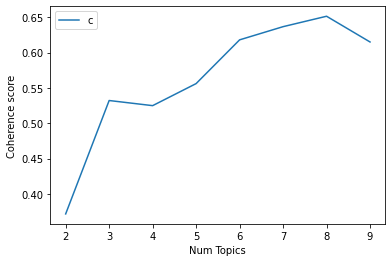

In [27]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print coherence values
for m, cv in zip(x, coherence_values):
    print("Num Topics = ", m, " has Coherence Value of", round(cv,4))

Num Topics =  2  has Coherence Value of 0.3717
Num Topics =  3  has Coherence Value of 0.5322
Num Topics =  4  has Coherence Value of 0.5249
Num Topics =  5  has Coherence Value of 0.5561
Num Topics =  6  has Coherence Value of 0.618
Num Topics =  7  has Coherence Value of 0.6367
Num Topics =  8  has Coherence Value of 0.6515
Num Topics =  9  has Coherence Value of 0.615


### Iteration 2 - correct number of topics

In [31]:
Iteration2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=8,
                                                  random_state=100,
                                                  update_every=1,
                                                  chunksize=100,
                                                  passes=10,
                                                  alpha='auto',
                                                  eta = 'auto',
                                                  per_word_topics=True)

In [32]:
# coherence score
coherence_model_2 = CoherenceModel(model=Iteration2, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_2 = coherence_model_2.get_coherence()
print('\nCoherence Score: ', coherence_2)

# perplexity score, measure of how good the model is. lower the better.
print('\nPerplexity: ', Iteration2.log_perplexity(corpus)) 


Coherence Score:  0.6517840551992742

Perplexity:  -7.59929600374486


In [33]:
pprint.pprint(Iteration2.print_topics())
doc_lda = Iteration2[corpus]

[(0,
  '0.032*"verlies" + 0.025*"burger" + 0.018*"landschap" + 0.017*"advies" + '
  '0.016*"strijd" + 0.016*"leefomgeving" + 0.016*"enorm" + 0.016*"ernstig" + '
  '0.016*"gebouw" + 0.016*"gevaarlijk"'),
 (1,
  '0.009*"lidstaat" + 0.007*"voorstel" + 0.006*"financieel" + 0.006*"regering" '
  '+ 0.005*"raad" + 0.005*"internationaal" + 0.005*"waarom" + 0.005*"product" '
  '+ 0.004*"kamer" + 0.004*"agenda"'),
 (2,
  '0.027*"haven" + 0.022*"raamwerk" + 0.017*"park" + 0.013*"inspraak" + '
  '0.010*"pagina" + 0.007*"plek" + 0.007*"naam" + 0.007*"bewoner" + '
  '0.007*"druk" + 0.007*"openbaar"'),
 (3,
  '0.007*"regionaal" + 0.007*"bodem" + 0.006*"ondernemer" + '
  '0.006*"perspectief" + 0.005*"samenwerking" + 0.005*"economisch" + '
  '0.005*"landschap" + 0.005*"kennis" + 0.005*"regio" + 0.004*"systeem"'),
 (4,
  '0.014*"mevrouw" + 0.010*"echt" + 0.010*"kijken" + 0.008*"denken" + '
  '0.008*"weten" + 0.007*"zitten" + 0.007*"graag" + 0.007*"even" + '
  '0.006*"dank" + 0.006*"gewoon"'),
 (5,
  '0.

# Hyperparameter tuning - took me about 4/5 hours to run so i wouldnt recommend it

In [34]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics= k, 
                                                random_state=100,
                                                chunksize=100,
                                                passes=10,
                                                alpha=a,
                                                eta = b,
                                                per_word_topics=True)
       
    coherence_model_lda3 = CoherenceModel(model=lda_model3, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
      

    return coherence_model_lda3.get_coherence()

In [35]:
import numpy as np
import tqdm

from gensim.utils import ClippedCorpus

In [36]:
grid = {}
grid['Validation_Set'] = {}

# Topic range
topic_range = range(4, 10, 1)

# Alpha parameter
alpha = list(np.arange(0.1, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.1, 1, 0.3))
beta.append('symmetric')

In [37]:
# Validation set
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), corpus]

corpus_title = ['75% Corpus', "100% Corpus"]
model_results ={'Validation_set': [],
                'Topics': [],
                'Alpha': [],
                'Beta': [],
                'Coherence': []
                }

In [38]:
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    for i in range(len(corpus_sets)):
        # Iterate through number of topics
        for k in topic_range:
            # Iterate through alpha values
            for a in alpha:
                # Iterate through beta values
                for b in beta:
                    # Obtain coherence value for given parameter values
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    
                    # Saving results of the model
                    model_results['Validation_set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    
    pd.DataFrame(model_results).to_csv('lda_tuning_results_new2.csv', index = False)
    pbar.close  

 44%|█████████████████████████████████▊                                          | 240/540 [1:19:21<1:50:24, 22.08s/it]

In [41]:
tuning_results = pd.read_csv('lda_tuning_results_new2.csv')
tuning_results[tuning_results['Topics'] == 8]

,Validation_set,Topics,Alpha,Beta,Coherence
80,75% Corpus,8,0.1,0.1,0.585225
81,75% Corpus,8,0.1,0.4,0.554947
82,75% Corpus,8,0.1,0.7000000000000001,0.523618
83,75% Corpus,8,0.1,symmetric,0.587451
84,75% Corpus,8,0.4,0.1,0.592575
85,75% Corpus,8,0.4,0.4,0.523597
86,75% Corpus,8,0.4,0.7000000000000001,0.539611
87,75% Corpus,8,0.4,symmetric,0.589682
88,75% Corpus,8,0.7000000000000001,0.1,0.600166
89,75% Corpus,8,0.7000000000000001,0.4,0.532873


In [39]:
Iteration3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=8,
                                                  random_state=100,
                                                  update_every=1,
                                                  chunksize=100,
                                                  passes=10,
                                                  alpha='symmetric',
                                                  eta = 0.7000000000000001,
                                                  per_word_topics=True)

In [40]:
# coherence score
coherence_model_3 = CoherenceModel(model=Iteration3, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_3 = coherence_model_3.get_coherence()
print('\nCoherence Score: ', coherence_3)

# perplexity score, measure of how good the model is. lower the better.
print('\nPerplexity: ', Iteration3.log_perplexity(corpus)) 


Coherence Score:  0.6849053477154081

Perplexity:  -7.614780970332581


In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(Iteration3, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.079123  0.070515       1        1  19.137972
5     -0.034855 -0.129379       2        1  17.830388
3     -0.067167 -0.098111       3        1  16.640706
0     -0.085837 -0.038813       4        1  16.089706
4     -0.065779  0.015698       5        1  13.367114
1     -0.077779  0.167416       6        1  12.383105
2      0.410539  0.012672       7        1   4.551010, topic_info=            Term         Freq        Total Category  logprob  loglift
590       verlie  1659.000000  1659.000000  Default  30.0000  30.0000
1179      burger  1582.000000  1582.000000  Default  29.0000  29.0000
374   leefomgeve  2434.000000  2434.000000  Default  28.0000  28.0000
983           ik  2233.000000  2233.000000  Default  27.0000  27.0000
272      fractie  1869.000000  1869.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
261        extra   659.803790  2133.252958   Topic7  -3.9435   1.9164
420       omgeve   563.850772  1648.771336   Topic7  -4.1007   2.0168
537           te   567.631585  1868.407010   Topic7  -4.0940   1.8985
40          geen   561.540265  2130.388228   Topic7  -4.1048   1.7564
415        nieuw   542.538730  1198.412058   Topic7  -4.1392   2.2973

[494 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
112       1  0.050784  aangeven
112       2  0.018467  aangeven
112       3  0.069252  aangeven
112       4  0.092335  aangeven
112       5  0.752533  aangeven
...     ...       ...       ...
3289      2  0.012140    zeggen
3289      3  0.963076    zeggen
3289      4  0.004047    zeggen
3289      5  0.004047    zeggen
3289      6  0.004047    zeggen

[2741 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 4, 1, 5, 2, 3])

In [42]:
pprint.pprint(Iteration3.print_topics())
doc_lda = Iteration3[corpus]

[(0,
  '0.027*"verlies" + 0.021*"burger" + 0.017*"industrie" + 0.015*"landschap" + '
  '0.014*"advies" + 0.014*"strijd" + 0.013*"gebouw" + 0.013*"leefomgeving" + '
  '0.013*"enorm" + 0.013*"verliezen"'),
 (1,
  '0.008*"lidstaat" + 0.006*"voorstel" + 0.005*"regering" + 0.005*"waarom" + '
  '0.005*"financieel" + 0.004*"internationaal" + 0.004*"raad" + '
  '0.004*"product" + 0.004*"opmerking" + 0.004*"kamer"'),
 (2,
  '0.024*"haven" + 0.020*"raamwerk" + 0.015*"park" + 0.011*"inspraak" + '
  '0.009*"pagina" + 0.007*"naam" + 0.007*"plek" + 0.006*"reactie" + '
  '0.006*"druk" + 0.006*"bewoner"'),
 (3,
  '0.007*"regionaal" + 0.006*"bodem" + 0.006*"ondernemer" + '
  '0.005*"perspectief" + 0.005*"samenwerking" + 0.005*"economisch" + '
  '0.005*"landschap" + 0.004*"energie" + 0.004*"kennis" + 0.004*"regio"'),
 (4,
  '0.014*"mevrouw" + 0.010*"echt" + 0.009*"kijken" + 0.008*"denken" + '
  '0.007*"zitten" + 0.007*"weten" + 0.007*"even" + 0.006*"graag" + '
  '0.006*"dank" + 0.006*"gewoon"'),
 (5,
  